In [216]:
# csce478    Final Project: Stock prediction          Fall 2020                       Due: Nov 19  11am
# contributers: Chungsu Kim, Devan Steiner, Jesse Reyes Cortes

# simple explanation


# all imported libraries
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('ggplot')
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn import tree
import pydotplus
from io import StringIO 
from sklearn.decomposition import PCA
from sklearn import svm
from matplotlib import cm
from sklearn.metrics import precision_score, accuracy_score, average_precision_score, recall_score




# helper functions
def accuracy(x,y):
    count = 0
    for i in range(0, len(x)):
        if(x[i]==1 and .5 < y[i]):
            count = count + 1
        elif(x[i]==0 and y[i] < .5):
            count = count + 1
    
    return count/len(x)




def partition(X, Y, t):     
    test_size = math.ceil(len(Y)*t)
    training_size = len(Y)-test_size
    training_data = X[0:training_size][:]
    testing_data = X[training_size+1:len(Y)] [:]
    training_vector = Y[0:training_size]
    testing_vector = Y[training_size+1:len(Y)]
    
    return training_data, testing_data, training_vector, testing_vector



In [3]:
# read in fake news data set
data = pd.read_csv("news-dataset.csv", delimiter=',')
data = data[data["URLs"].notna()]
data = data[data["Headline"].notna()]
data = data[data["Body"].notna()]
data = data[data["Label"].notna()]
data.reset_index(inplace=True)

# # extract data
X = pd.DataFrame([])
X["URLs"] = data["URLs"]
X["Headline"] = data["Headline"]
X["Body"] = data["Body"]

Y = data["Label"]

data.describe(include='all')


,index,URLs,Headline,Body,Label
count,3988.000000,3988,3988,3988,3988.000000
unique,NaN,3332,2823,2863,NaN
top,NaN,http://beforeitsnews.com/sports/2017/09/930-tr...,2017 Fantasy Football Quarterback Rankings - W...,A Potato Battery Can Light up a Room for Over ...,NaN
freq,NaN,5,6,143,NaN
mean,2005.714644,NaN,NaN,NaN,0.468405
std,1157.218870,NaN,NaN,NaN,0.499063
min,0.000000,NaN,NaN,NaN,0.000000
25%,1004.750000,NaN,NaN,NaN,0.000000
50%,2006.500000,NaN,NaN,NaN,0.000000
75%,3007.250000,NaN,NaN,NaN,1.000000


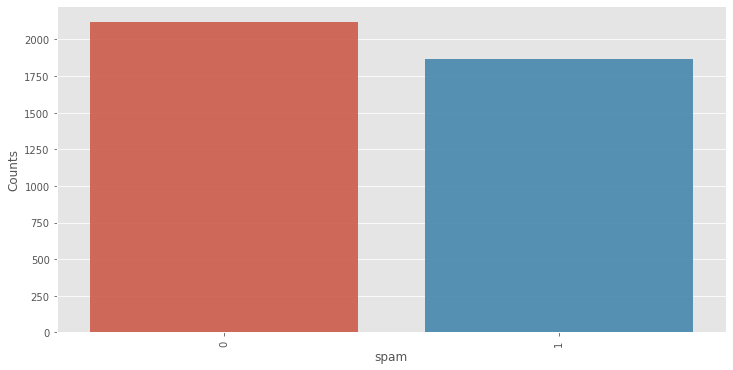

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

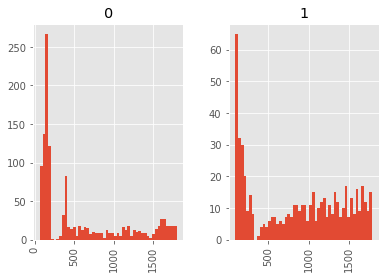

In [3]:
# visualization of training data

label_counts = Y.value_counts()
plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)

plt.xticks(rotation = 'vertical')
plt.xlabel('spam', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()
# get column "length" the stores the length of the body of each article
data["length"] = data["Body"].map(lambda text: len(text))

data.groupby('Label').length.describe()
articles_subset = data[data.length < 1800]
articles_subset.hist(column='length', by='Label', bins=50)

In [4]:
# text preprocessing


lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

X_lem = X.Body.map(lambda text: ' '.join(lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text.lower())))

X_stem = X.Body.map(lambda text: ' '.join(stemmer.stem(w) for w in nltk.word_tokenize(text.lower())))


# remove stop words & convert to numerical feature vectors

cv = CountVectorizer(lowercase=True, stop_words='english')
X_lem = cv.fit_transform(X_lem)

cv2 = CountVectorizer(lowercase=True, stop_words='english')
X_stem = cv2.fit_transform(X_stem)

X_lem = X_lem.toarray()
X_stem = X_stem.toarray()

In [227]:
# train

# multinomial naive bayes classifier ; assignment 3 part A
class Multinomial_NB:
    def __init__(self, alpha=1.0):
        self.X = np.array([])
        self.Y = np.array([])
        self.alpha = alpha
        self.prior_h = 0
        self.prior_s = 0
        self.h_total = 0
        self.s_total = 0
        self.feature_h = []
        self.feature_s = []
        
    def fit(self, X, Y, **kwargs):
        self.X = X
        self.Y = Y
        
        # save feature counts for spam & ham
        self.feature_h = np.zeros(( len(self.X[0])))
        self.feature_s = np.zeros(( len(self.X[0])))
        
        if "alpha" in kwargs:
            self.alpha = kwargs["alpha"]
        
        h_count = 0
        s_count = 0
        
        for i in range(0, len(self.X)):
            
            # count total for real & fake
            # real news
            if(self.Y[i]==1):
                self.feature_s = np.add(self.feature_s, self.X[i])
                s_count = s_count + 1
            # fake news
            else:
                self.feature_h = np.add(self.feature_h, self.X[i])
                h_count = h_count + 1
                
        self.s_total = sum(self.feature_s)
        self.h_total = sum(self.feature_h)
                
         
        self.prior_h = (self.alpha + h_count)/(2*self.alpha + (h_count + s_count))
        self.prior_s = (self.alpha + s_count)/(2*self.alpha + (h_count + s_count))

        
        
    def predict(self, X):
        
        predict = []
        
        log_post = self.predict_log_proba(X)
        
        for i in range(0, len(X)):
         
            prob_s = math.log(self.prior_s) + log_post[i][0]
            prob_h = math.log(self.prior_h) + log_post[i][1]
                
            if(prob_s > prob_h):
                predict.append(1)
            else:
                predict.append(0)
                
        return predict
    
    
    
    def predict_log_proba(self, X):
        
        log_post = np.zeros((len(X),2))
        
        for i in range(0, len(X)):
            
            #predicting spam
            post_s = 0
            #predicting ham
            post_h = 0
            
            for j in range(0, len(X[i])):
                p_s = self.alpha + self.feature_s[j]
                p_h = self.alpha + self.feature_h[j]
                    
                post_s = post_s + (self.X[i][j] * math.log(p_s/(2*self.alpha + self.s_total)))
                post_h = post_h + (self.X[i][j] * math.log(p_h/(2*self.alpha + self.h_total)))
            
            log_post[i][0] = post_s
            log_post[i][1] = post_h
                
        return log_post

    
    
# initialize model
model = Multinomial_NB()

# hyper parameters
alpha = [0.001, 1, 2] 
data = [X_lem, X_stem]

count = 0
print("Multinomial NB(assignment 3)")
# running model on hyper parameters
for x in data:
    
    if count == 0:
        print("Lemmatized data:")
    else:
        print("Stemmatized data:")
        
    for a in alpha:
        
        # split data set to gathering training data
        x_train ,x_test, y_train, y_test = partition(x, Y, .20) 
        # train model
        model.fit(x_train, y_train, alpha=a)
        
        # predict labels
        y_hat = model.predict(x_test)
        
        print("alpha: ", a, 
              "\naccuracy: ", accuracy_score(np.array(y_test), y_hat), 
              "\nprecision score: ",precision_score(np.array(y_test), y_hat),
              "\nrecall: ", recall_score(np.array(y_test), y_hat), "\n")
    
    # update count
    count = 1

Multinomial NB(assignment 3)
Lemmatized data:
alpha:  0.001 
accuracy:  0.5056461731493099 
precision score:  0.46994535519125685 
recall:  0.46236559139784944 

alpha:  1 
accuracy:  0.4993726474278545 
precision score:  0.46321525885558584 
recall:  0.45698924731182794 

alpha:  2 
accuracy:  0.4993726474278545 
precision score:  0.46301369863013697 
recall:  0.4543010752688172 

Stemmatized data:
alpha:  0.001 
accuracy:  0.5056461731493099 
precision score:  0.46994535519125685 
recall:  0.46236559139784944 

alpha:  1 
accuracy:  0.5006273525721455 
precision score:  0.46467391304347827 
recall:  0.4596774193548387 

alpha:  2 
accuracy:  0.5006273525721455 
precision score:  0.46467391304347827 
recall:  0.4596774193548387 



In [219]:
# comparison to sklearn
nb_model = MultinomialNB()

# lem data
x_train ,x_test, y_train, y_test = partition(X_lem, Y, .20) 
nb_model.fit(x_train, y_train)
y_hat = nb_model.predict(x_test)
print("Multinomial NB Sklearn(lem) \naccuracy(lem): ", accuracy_score(np.array(y_test), y_hat), 
      "\nprecision score: ",precision_score(np.array(y_test), y_hat),
      "\nrecall: ", recall_score(np.array(y_test), y_hat), "\n") 

# stem data
x_train ,x_test, y_train, y_test = partition(X_stem, Y, .20) 
nb_model.fit(x_train, y_train)
y_hat = nb_model.predict(x_test)
print("Multinomial NB Sklearn(lem) \naccuracy(stem): ", accuracy_score(np.array(y_test), y_hat), 
      "\nprecision score: ",precision_score(np.array(y_test), y_hat),
      "\nrecall: ", recall_score(np.array(y_test), y_hat), "\n") 


Multinomial NB Sklearn(lem) 
accuracy(lem):  0.9774153074027604 
precision score:  0.9732620320855615 
recall:  0.978494623655914 

Multinomial NB Sklearn(lem) 
accuracy(stem):  0.973651191969887 
precision score:  0.968 
recall:  0.9758064516129032 



In [223]:
# decision tree classifier
tree_lem_model = DecisionTreeClassifier(criterion="entropy")
tree_model = DecisionTreeClassifier(criterion="entropy")

# lem data
x_train ,x_test, y_train, y_test = partition(X_lem, Y, .20) 
tree_lem_model.fit(x_train, y_train)
y_hat = tree_lem_model.predict(x_test)
print("Decision Tree Classifer Sklearn(lem) \naccuracy: ", accuracy_score(np.array(y_test), y_hat), 
      "\nprecision: ", precision_score(np.array(y_test), y_hat),
      "\nrecall: ", recall_score(np.array(y_test), y_hat), "\n")

# stem data
x_train ,x_test, y_train, y_test = partition(X_stem, Y, .20) 
tree_model.fit(x_train, y_train)
y_hat = tree_model.predict(x_test)
print("Decision Tree Classifer Sklearn(stem) \naccuracy: ", accuracy_score(np.array(y_test), y_hat), 
      "\nprecision: ", precision_score(np.array(y_test), y_hat),
      "\nrecall: ", recall_score(np.array(y_test), y_hat), "\n")

Decision Tree Classifer Sklearn(lem) 
accuracy:  0.958594730238394 
precision:  0.9695290858725761 
recall:  0.9408602150537635 

Decision Tree Classifer Sklearn(stem) 
accuracy:  0.9623588456712673 
precision:  0.9723756906077348 
recall:  0.946236559139785 



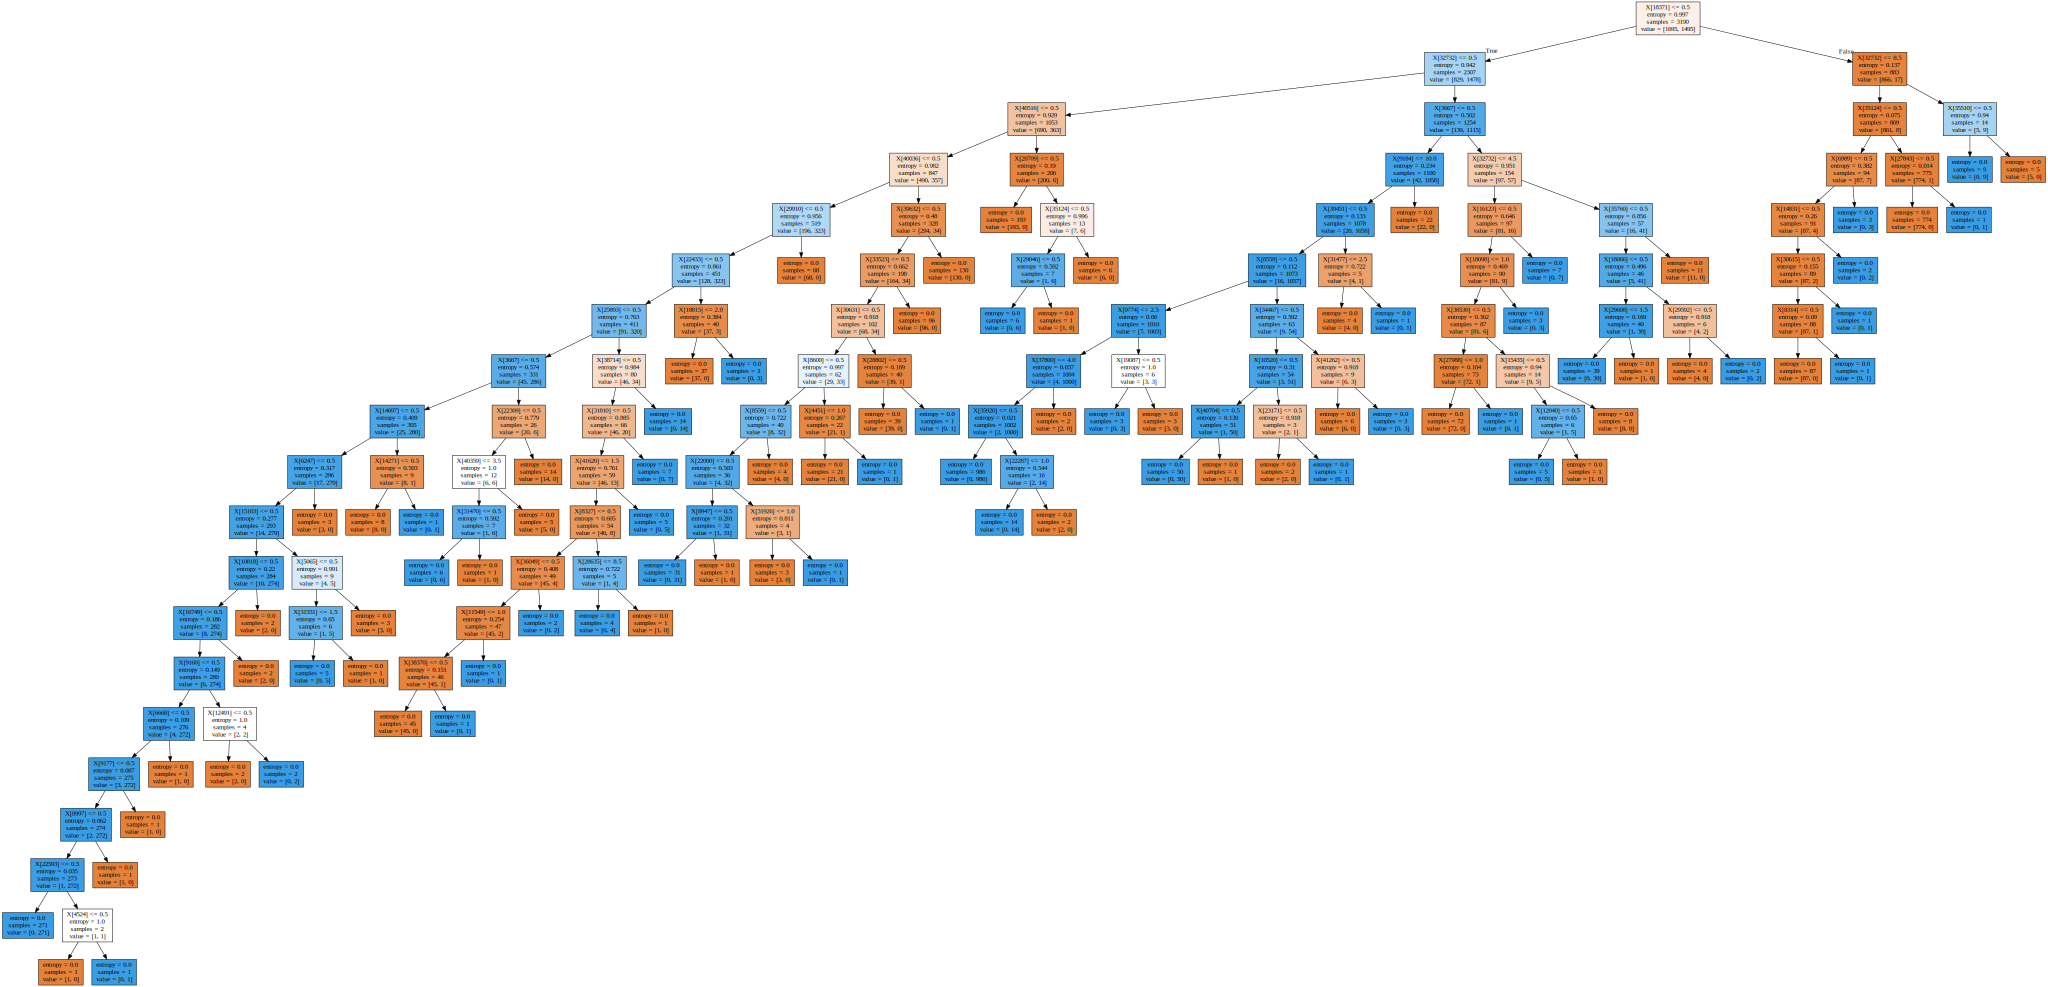

In [224]:
# DOT data
dot_data = tree.export_graphviz(tree_lem_model, out_file=None, 
                                filled=True)

# export graph
grap=pydotplus.graph_from_dot_data(dotfile.getvalue())
grap.write_png("dtree.png")

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph.render()
graph



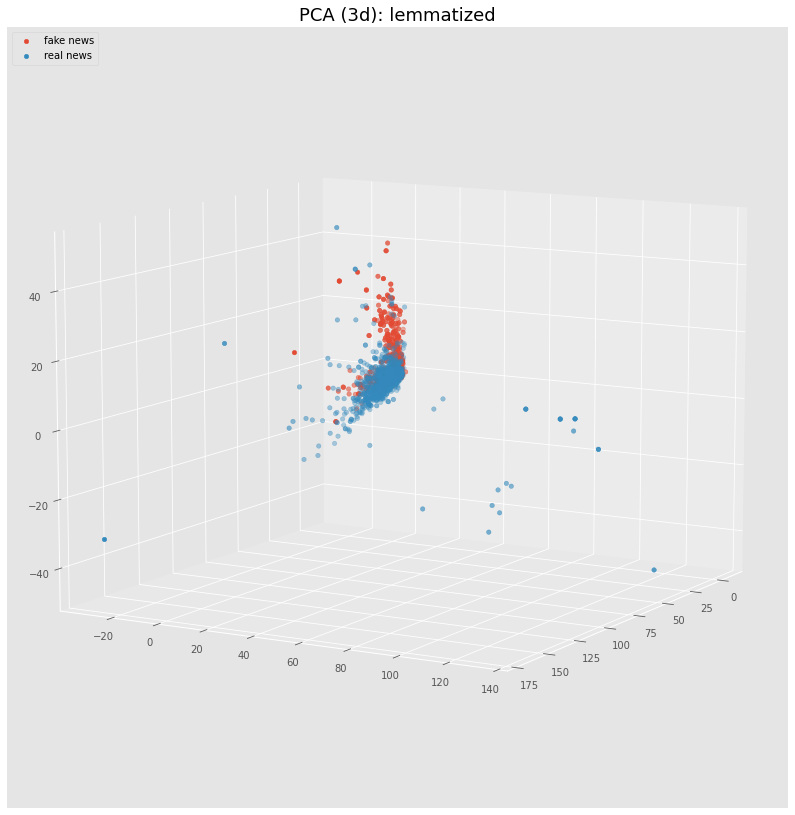

In [225]:
# pca on data to reduce to 2 features
model = PCA(n_components=3)
pca_x_lem = model.fit_transform(X_lem)

# # seperate fake & real
rn_lem = pca_x_lem[(Y > 0).ravel()]
fn_lem = pca_x_lem[(Y < 1).ravel()]

# Draw a scatter plot
fig = plt.figure(figsize=(14,16))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(fn_lem[:, 0], fn_lem[:, 1],fn_lem[:, 2], "b", label="fake news")
ax.scatter(rn_lem[:, 0], rn_lem[:, 1],rn_lem[:, 2], "r", label="real news")

plt.title("PCA (3d): lemmatized", fontsize=18)
plt.legend(loc=2)

ax.view_init(10, 30)
plt.draw()


Sklearn SVM(lem 3d): 
accuracy:  0.7716436637390214 
precision:  0.8298611111111112 
recall:  0.6424731182795699 



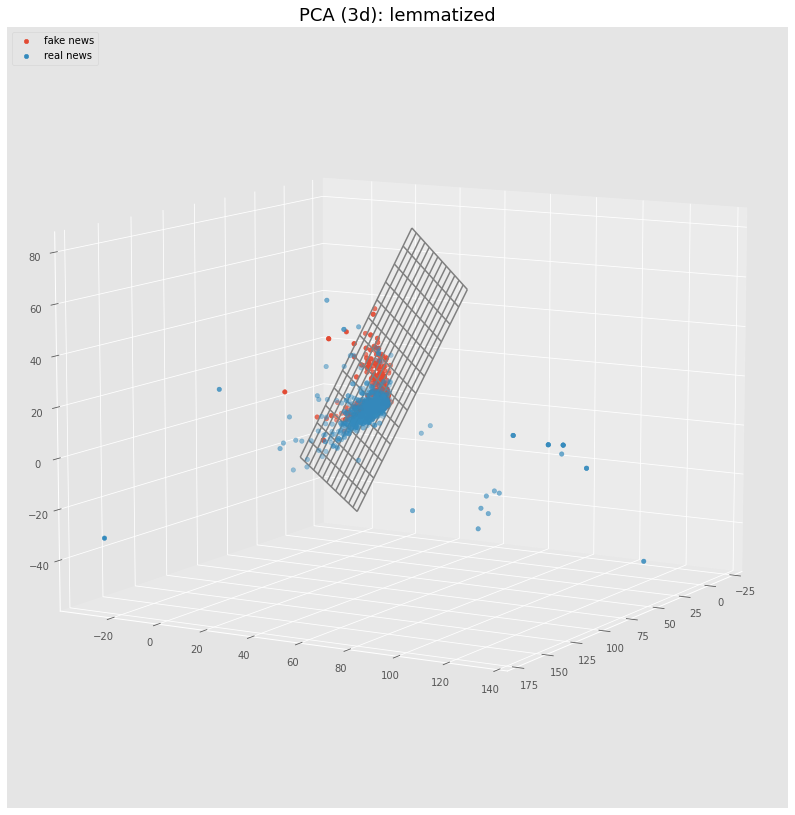

In [226]:
# run PCA data with SVM
svm_model = svm.SVC(kernel='linear')

#partition PCA data
x_train ,x_test, y_train, y_test = partition(pca_x_lem, Y, .20) 

svm_model.fit(x_train, y_train)
y_hat = svm_model.predict(x_test)

print("Sklearn SVM(lem 3d): \naccuracy: ",accuracy_score(np.array(y_test), y_hat),
     "\nprecision: ", precision_score(np.array(y_test), y_hat),
     "\nrecall: ", recall_score(np.array(y_test), y_hat), "\n") 


db = lambda x,y: (-svm_model.intercept_[0]-svm_model.coef_[0][0]*x-svm_model.coef_[0][1]*y) / svm_model.coef_[0][2]
tmp = np.linspace(-20,30,40)
x,y = np.meshgrid(tmp,tmp)

# Draw a scatter plot with decision boundry
fig = plt.figure(figsize=(14,16))
ax = fig.add_subplot(111, projection='3d')


ax.plot_wireframe(x, y, db(x,y) ,rstride=3, cstride=3, color='grey')

ax.scatter(fn_lem[:, 0], fn_lem[:, 1],fn_lem[:, 2], "b", label="fake news")
ax.scatter(rn_lem[:, 0], rn_lem[:, 1],rn_lem[:, 2], "r", label="real news")

plt.title("PCA (3d): lemmatized", fontsize=18)
plt.legend(loc=2)

ax.view_init(10, 30)
plt.draw()


In [228]:
# test real world samples
